In [32]:
pip install pymorphy2

In [33]:
pip install emoji

In [34]:
pip install catboost

In [35]:
from bs4 import BeautifulSoup
import requests as req
import pandas as pd
import numpy as np
import emoji
import re
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Dense
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import nltk
from nltk.corpus import stopwords
import pymorphy2
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from keras.regularizers import l2


# Сбор, очистка, подготовка данных

In [ ]:
from sklearn.metrics import confusion_matrix

## Сбор данных


In [36]:
# Список имен файлов
file_names = ['messages8(дептранс).html', 'messages9(дептранс).html', 'messages10(дептранс).html',
              'messages(ржд).html', 'messages3(ржд).html', 'messages4(ржд).html',
              'messages(авиа).html', 'messages2(авиа).html', 'messages3(авиа).html']

# Словарь для хранения объектов BeautifulSoup
soups = {}

# Цикл по именам файлов
for i, file_name in enumerate(file_names, 1):
    with open(file_name, 'rb') as file:
        content = file.read()
        soups[f'soup{i}'] = BeautifulSoup(content, 'html.parser')

# Объединение объектов BeautifulSoup
s1 = BeautifulSoup("", 'html.parser')
s1.append(soups['soup1'])
s1.append(soups['soup2'])
s1.append(soups['soup3'])

s2 = BeautifulSoup("", 'html.parser')
s2.append(soups['soup4'])
s2.append(soups['soup5'])
s2.append(soups['soup6'])

s3 = BeautifulSoup("", 'html.parser')
s3.append(soups['soup7'])
s3.append(soups['soup8'])
s3.append(soups['soup9'])

In [37]:
s3

<!DOCTYPE html>

<html>
<head>
<meta charset="utf-8"/>
<title>Exported Data</title>
<meta content="width=device-width, initial-scale=1.0" name="viewport"/>
<link href="css/style.css" rel="stylesheet"/>
<script src="js/script.js" type="text/javascript">
</script>
</head>
<body onload="CheckLocation();">
<div class="page_wrap">
<div class="page_header">
<div class="content">
<div class="text bold">
Авиаторщина 
     </div>
</div>
</div>
<div class="page_body chat_page">
<div class="history">
<div class="message service" id="message-1">
<div class="body details">
12 January 2020
      </div>
</div>
<div class="message service" id="message1">
<div class="body details">
Channel «Налетались» created
      </div>
</div>
<div class="message service" id="message-2">
<div class="body details">
10 June 2020
      </div>
</div>
<div class="message default clearfix" id="message55">
<div class="pull_left userpic_wrap">
<div class="userpic userpic2" style="width: 42px; height: 42px">
<div class="init

In [38]:
# Ищем только те посты где написан текст, заменя тэги на пробел, чтобы не было слияний
text1 = [i.get_text(" ", strip=True) for i in s1.find_all('div', class_='text')]
text2 = [i.get_text(" ", strip=True) for i in s2.find_all('div', class_='text')]
text3 = [i.get_text(" ", strip=True) for i in s3.find_all('div', class_='text')]



In [39]:

# Собираем датафрейм
df1 = pd.DataFrame({'text': text1, 'id': 'транспорт москвы'})
df2 = pd.DataFrame({'text': text2, 'id': 'железнодорожный'})
df3 = pd.DataFrame({'text': text3, 'id': 'авиа'})




# Соединяем в общий датафрейм
df = pd.concat([df1, df2, df3], ignore_index=True)
df

text                id
0                                       Дептранс Москвы  транспорт москвы
1     В декабре исполнилось 120 лет со дня рождения ...  транспорт москвы
2     Доброе утро! По прогнозу синоптиков, в городе ...  транспорт москвы
3     Территория бывшего автозавода ЗИЛ стремительно...  транспорт москвы
4     🚇 На всех турникетах метро и МЦК начался откры...  транспорт москвы
...                                                 ...               ...
5459  Испытания отечественных кресел для ипортозамещ...              авиа
5460  Росавиация раскрыла число авиационных инцидент...              авиа
5461  Аэропорт Краснодара заработает 25 декабря. 25 ...              авиа
5462  Аэрофлоту предъявили коллективный иск за отмен...              авиа
5463  Россия планирует произвести свыше тысячи самол...              авиа

[5464 rows x 2 columns]

## Предобработка данных

In [40]:
df = df.drop_duplicates()
print('Размер датасета:')
print(f'{len(df)}\n')

print('Пропущенные значения:')
print(f'{df.isnull().sum()}\n')

print('Баланс классов:')
print(df["id"].value_counts())


Размер датасета:
5447

Пропущенные значения:
text    0
id      0
dtype: int64

Баланс классов:
id
авиа                2463
железнодорожный     1785
транспорт москвы    1199
Name: count, dtype: int64


In [41]:
nltk.download('stopwords')
# Функция для удаления лишнего из текста
def filt(t):
    t = str(t)
    t = emoji.replace_emoji(t, replace='') # Удаление всех эмодзи из текста с заменой на пустую строку
    t = re.sub(r'[\xa0\u200e\u200b]', '', t)
    t = re.sub(r'@\S+|#\w+', '', t) # Удаление упоминаний пользователей (начинающихся с символа @) и хэштегов (начинающихся с символа #) из текста.
    t = re.sub(r'\b[\w\.-]+@[\w\.-]+\.\w+\b', '', t) # Удаление адресов электронной почты из текста.
    t = re.sub(r'\d+', '', t) # Удаление цифр из текста.
    t = re.sub(r'[^\w\s]','', t) # Удаление знаков пунктуации из текста.
    t = re.sub(r'http\S+|https\S+', '', t) # Удаление ссылок на веб-страницы (URL) из текста.
    t = t.lower()
    stop = set(stopwords.words('russian'))|set(stopwords.words("english"))
    t = ' '.join([w for w in t.split() if w.lower() not in stop])
    return t
df['text'] = df['text'].apply(filt)

df

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
<ipython-input-41-ad9a51da87da>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(filt)


text                id
0                                       дептранс москвы  транспорт москвы
1     декабре исполнилось лет дня рождения архитекто...  транспорт москвы
2     доброе утро прогнозу синоптиков городе весь де...  транспорт москвы
3     территория бывшего автозавода зил стремительно...  транспорт москвы
4     турникетах метро мцк начался открытый тест опл...  транспорт москвы
...                                                 ...               ...
5459  испытания отечественных кресел ипортозамещенно...              авиа
5460  росавиация раскрыла число авиационных инцидент...              авиа
5461  аэропорт краснодара заработает декабря декабря...              авиа
5462  аэрофлоту предъявили коллективный иск отмененн...              авиа
5463  россия планирует произвести свыше тысячи самол...              авиа

[5447 rows x 2 columns]

## подготовка данных

In [42]:

# Токенизируем и лемматизируем текст
morph = pymorphy2.MorphAnalyzer()
df['text'] = df['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
X = tokenizer.texts_to_sequences(df['text'])


maxlen = df['text'].apply(lambda x: len(x.split())).max()
X = pad_sequences(X, maxlen=maxlen,padding = 'post')
X

<ipython-input-42-11e5c00a684f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(lambda x: ' '.join([morph.parse(word)[0].normal_form for word in x.split()]))


array([[3213,    4,    0, ...,    0,    0,    0],
       [ 178, 4278,    1, ...,    0,    0,    0],
       [1023,  689,  679, ...,    0,    0,    0],
       ...,
       [  21,  836, 1504, ...,    0,    0,    0],
       [   7, 3054, 2370, ...,    0,    0,    0],
       [   9,  134, 1457, ...,    0,    0,    0]], dtype=int32)

In [54]:
c = list(df['id'].values)
e = LabelEncoder()
e.fit(c)
y = e.transform(c)
y

array([2, 2, 2, ..., 0, 0, 0])

In [44]:
y.shape

(5447,)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Модель

In [ ]:
X_train.shape

(4357, 441)

In [ ]:
tokenizer.word_index

{'год': 1,
 'авиакомпания': 2,
 'самолёт': 3,
 'москва': 4,
 'пассажир': 5,
 'который': 6,
 'аэрофлот': 7,
 'поезд': 8,
 'россия': 9,
 'новый': 10,
 'рейс': 11,
 'это': 12,
 'ржд': 13,
 'тыс': 14,
 'транспорт': 15,
 'млн': 16,
 'российский': 17,
 'работа': 18,
 'также': 19,
 'станция': 20,
 'аэропорт': 21,
 'время': 22,
 'маршрут': 23,
 'первый': 24,
 'компания': 25,
 'перевозка': 26,
 'день': 27,
 'стать': 28,
 'воздушный': 29,
 'полёт': 30,
 'наш': 31,
 'быть': 32,
 'свой': 33,
 'максим': 34,
 'один': 35,
 'росавиация': 36,
 'число': 37,
 'сегодня': 38,
 'вокзал': 39,
 'поездка': 40,
 'ликсут': 41,
 'билет': 42,
 'московский': 43,
 'метро': 44,
 'система': 45,
 'победа': 46,
 'человек': 47,
 'движение': 48,
 'дорога': 49,
 'другой': 50,
 'место': 51,
 'пилот': 52,
 'такой': 53,
 'город': 54,
 'сергей': 55,
 'тонна': 56,
 'путь': 57,
 'вагон': 58,
 'страна': 59,
 'направление': 60,
 'состав': 61,
 'млрд': 62,
 'проект': 63,
 'мочь': 64,
 'работать': 65,
 'транспортный': 66,
 'сообщить

In [ ]:


vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=100, input_length=maxlen))
model.add(Dropout(0.5))
model.add(LSTM(64,return_sequences=True, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(LSTM(32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units=3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

m = model.fit(X_train, y_train, epochs=15, batch_size=128, validation_split=0.2)

Epoch 1/15
28/28 [==============================] - 64s 2s/step - loss: 2.8035 - accuracy: 0.4511 - val_loss: 2.1703 - val_accuracy: 0.5642
Epoch 2/15
28/28 [==============================] - 57s 2s/step - loss: 1.4482 - accuracy: 0.8143 - val_loss: 0.9230 - val_accuracy: 0.9025
Epoch 3/15
28/28 [==============================] - 58s 2s/step - loss: 0.7458 - accuracy: 0.9489 - val_loss: 0.5603 - val_accuracy: 0.9564
Epoch 4/15
28/28 [==============================] - 57s 2s/step - loss: 0.4422 - accuracy: 0.9753 - val_loss: 0.3685 - val_accuracy: 0.9622
Epoch 5/15
28/28 [==============================] - 56s 2s/step - loss: 0.2762 - accuracy: 0.9871 - val_loss: 0.2613 - val_accuracy: 0.9690
Epoch 6/15
28/28 [==============================] - 58s 2s/step - loss: 0.1877 - accuracy: 0.9934 - val_loss: 0.2392 - val_accuracy: 0.9622
Epoch 7/15
28/28 [==============================] - 57s 2s/step - loss: 0.1407 - accuracy: 0.9917 - val_loss: 0.1954 - val_accuracy: 0.9713
Epoch 8/15
28/28 [==

## Оценка Производительности модели и визуализация

In [ ]:

loss_test, acc_test = model.evaluate(X_test, y_test)

loss_train, acc_train = model.evaluate(X_train, y_train)


pred = model.predict(X_test)



pred_classes = np.argmax(pred, axis=1)

precision = precision_score(y_test, pred_classes, average='weighted')
recall = recall_score(y_test, pred_classes, average='weighted')
f1 = f1_score(y_test, pred_classes, average='weighted')

print(f'Точность на обучающем наборе: {acc_train}, Точность на тестовом наборе: {acc_test}')

print(f'Precision - test: {precision}')
print(f'Recall - test: {recall}')
print(f'F1-score - test: {f1}')

35/35 [==============================] - 3s 76ms/step
Точность на обучающем наборе: 0.9889832735061646, Точность на тестовом наборе: 0.9669724702835083
Precision - test: 0.9673973119004281
Recall - test: 0.9669724770642202
F1-score - test: 0.9670739300007113


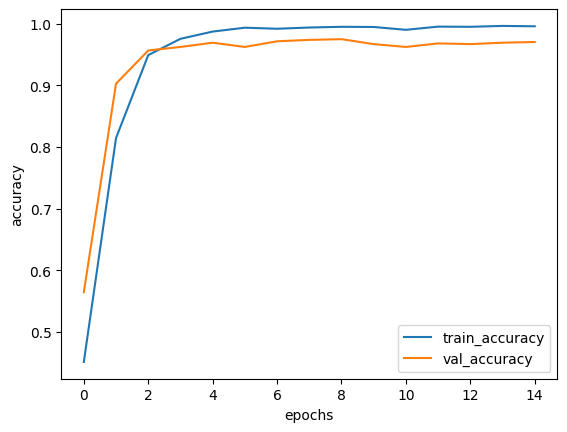

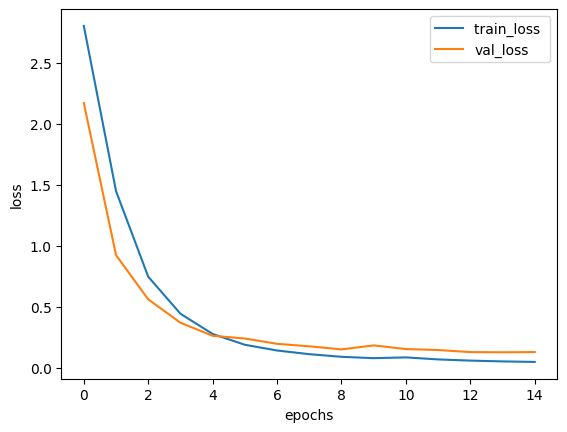

In [ ]:
plt.plot(m.history['accuracy'], label='train_accuracy')
plt.plot(m.history['val_accuracy'], label='val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(m.history['loss'], label='train_loss ')
plt.plot(m.history['val_loss'], label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

35/35 [==============================] - 7s 173ms/step


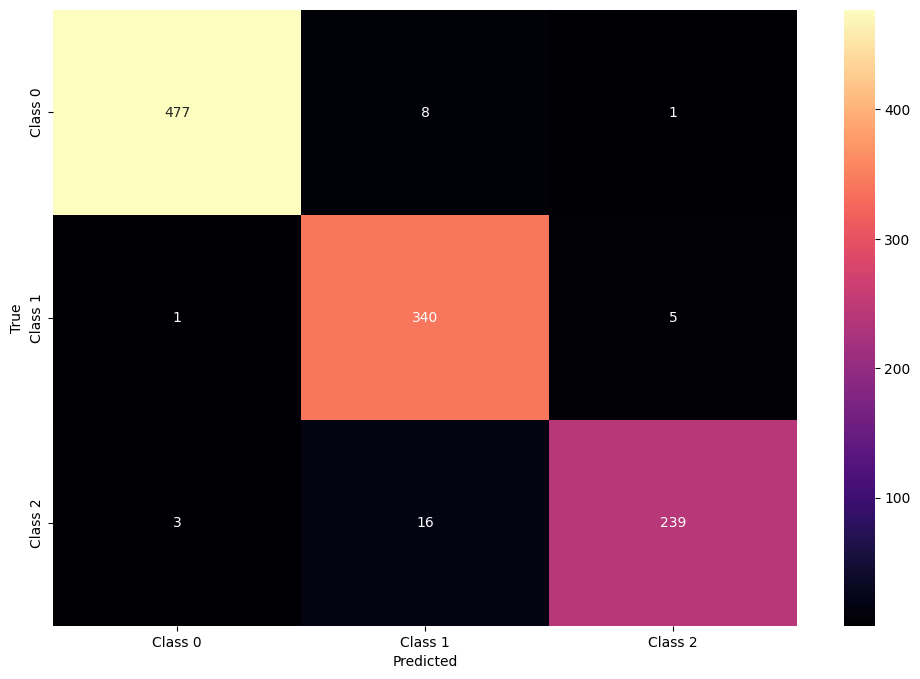

In [ ]:

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Визуализация матрицы ошибок с помощью seaborn
class_names = ['Class 0', 'Class 1', 'Class 2']
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="magma", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Предсказание класса для нового текста

In [ ]:
# Предсказание класса для нового текста
import numpy as np


def clear_t(text):
    text = filt(text)
    text = ' '.join([morph.parse(word)[0].normal_form for word in text.split()])
    text_sequence = tokenizer.texts_to_sequences([text])
    text_sequence = pad_sequences(text_sequence)
    return text_sequence
new_text = "Авиакомпания - была вынуждена преркатить свою работу 😞"

new_text = clear_t(new_text)
predict = model.predict(new_text)
predict_class = np.argmax(predict)
print(e.inverse_transform([predict_class])[0])

new_text1 = "🚇 Прокатимся на метро москвы до Красной площади! Невероятный вид 🏰 и атмосфера 🌆 ждут каждого, кто решит отправиться в это увлекательное путешествие. План поездки здесь: https://www.metro.ru/как-доехать-до-Красной-площади"

new_text1 = clear_t(new_text1)
predict1 = model.predict(new_text1)
predict_class1 = np.argmax(predict1)
print(e.inverse_transform([predict_class1])[0])


new_text2 = "🚆 Поехали в Прагу на поезде по железной дороге! Увидим Карлов мост 🌉 и насладимся аутентичным чешским пивом 🍺. Подробности поездки здесь: https://www.railway.ru/как-доехать-до-Карлова-моста"

new_text2 = clear_t(new_text2)
predict2 = model.predict(new_text2)
predict_class2 = np.argmax(predict2)
print(e.inverse_transform([predict_class2])[0])


1/1 [==============================] - 1s 1s/step
авиа
1/1 [==============================] - 0s 29ms/step
транспорт москвы
1/1 [==============================] - 0s 33ms/step
железнодорожный
